# Timing code in `jupyter`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from time import time
from tqdm import tqdm
from scipy.stats import linregress

# Quick-and-dirty profiling with IPython magics

`%time` will print out how long a one-line cell took to run. Use `%%time` for a multi-line cell.

* The `CPU time` is how long the CPU spent dedicated to the process; it's [broken up](https://en.wikipedia.org/wiki/CPU_time#Subdivision) by time spent in the user space (`user`) versus kernel space (`sys`).
* the `Wall time` is the total change in the system clock from start to finish.

In [2]:
A = np.random.normal(0, 1, (10,10))
B = np.random.normal(0, 1, (10,10))

In [3]:
%time C = A.dot(B)

CPU times: user 48 µs, sys: 41 µs, total: 89 µs
Wall time: 96.1 µs


In [4]:
%%time
C = A.dot(B)
C += A

CPU times: user 828 µs, sys: 886 µs, total: 1.71 ms
Wall time: 1.55 ms


Especially for short, fast computations, the time you measure here may isn't always accurate- the overhead of using Jupyter or any other hiccups on your machine may cause it to overestimate. Use `%timeit` or `%%timeit` to run several times and report the best result.

In [5]:
%timeit C = A.dot(B)

1.24 µs ± 88.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


`%timeit` will try to guess how many loops and runs to do, so it won't run a zillion trials if the first one takes an hour. You can manually specify the parameters if you want; `-n` sets the number of times to run the code in a loop and `-r` sets how many times to run the loop.

So it'll take the best (fastest) run and divide the time it took by the number of loops in the run.

In [6]:
%timeit -n 1000 -r 50 C = A.dot(B)

1.62 µs ± 532 ns per loop (mean ± std. dev. of 50 runs, 1000 loops each)


## Empirical scaling of matrix multiplication with `numpy`

We can compute the wall time by calling `time.time()` before and after a computation. Let's generate a bunch of square matrices of different dimension and measure how long it takes to multiply them.

In [7]:
N = np.arange(1, 2501, 10)
t = np.zeros(N.shape)

In [8]:
# for each matrix size
for i in tqdm(range(len(N))):
    # make some random matrices
    A = np.random.normal(0, 1, (N[i], N[i]))
    B = np.random.normal(0, 1, (N[i], N[i]))
    # write down the time before multiplying
    t0 = time()
    # do the multiplication
    C = A.dot(B)
    # write down the time after
    t1 = time()
    # record the difference
    t[i] = t1 - t0

100%|██████████| 250/250 [02:14<00:00,  1.86it/s]


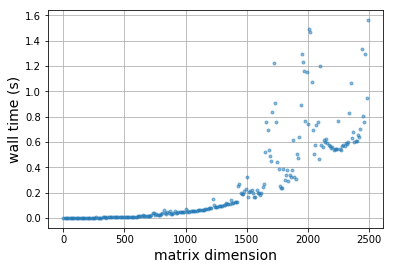

In [9]:
plt.plot(N,t, ".", alpha=0.5)
plt.xlabel("matrix dimension", fontsize=14)
plt.ylabel("wall time (s)", fontsize=14)
plt.grid("on");

## Measuring the scaling relationship

We could look up the big O for matrix multiplication, but that isn't guaranteed to be exactly what we see in practice. Really smart people have put a ton of work into linear algebra libraries, so there's a bunch of vectorization and parallelization happening that might distort the scaling relations.

For smaller matrices the wall time might be dominated by overhead, and for larger matrices memory constraints might limit what can be done in parallel.

If we assume that, in general, the wall time is an exponent $f$ of the matrix size,

$t \propto N^{f}$

then we can take the log of each and estimate $f$ using a linear regression:

$\log(t) = f\log(N) + B$

The lower and upper end appear to have outliers, so let's fit off the middle:

In [10]:
slope, intercept, rval, pval, stderr = linregress(np.log(N)[50:-50], np.log(t)[50:-50])

In [11]:
slope

3.2676274798336706

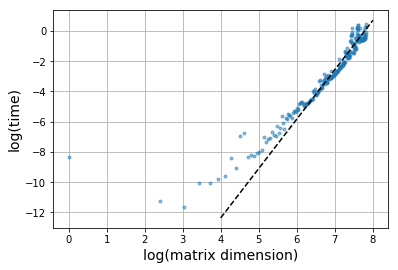

In [12]:
plt.plot(np.log(N),np.log(t), ".", alpha=0.5)
plt.plot([4, 8], [4*slope+intercept, slope*8+intercept], "k--")
plt.xlabel("log(matrix dimension)", fontsize=14)
plt.ylabel("log(time)", fontsize=14)
plt.grid("on");